### Model preparation

In [1]:
import torch
import torch.nn as nn
from PIL import Image
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from torchvision.models import densenet121, densenet169
from torch.utils.data import Dataset
from torchvision import transforms

num_classes = 10

model = densenet169()
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

### Dataset preparation

In [2]:
class SpectrogramDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, label_map=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = label_map or self._build_label_map()

    def _build_label_map(self):
        labels = self.annotations['genre'].unique()
        return {label: idx for idx, label in enumerate(sorted(labels))}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        filename = self.annotations.iloc[idx, 0]
        subfolder = filename.split('.')[0]
        filename = filename[:-4] + '.png'
        img_name = os.path.join(self.root_dir, subfolder, filename)
        image = Image.open(img_name).convert('RGB')
        label_str = self.annotations.iloc[idx, 1]
        label = self.label_map[label_str]

        if self.transform:
            image = self.transform(image)

        return image, label


In [3]:
'''
from sklearn.model_selection import train_test_split
csv_file = 'project_data/tracks.csv'
df = pd.read_csv(csv_file)
df = df.sample(frac=1).reset_index(drop=True)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['genre'])
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['genre'])

train_df.to_csv('project_data/train.csv', index=False)
valid_df.to_csv('project_data/valid.csv', index=False)
test_df.to_csv('project_data/test.csv', index=False)

print("Data has been split into train.csv, valid.csv, and test.csv with balanced genres.")
'''

'\nfrom sklearn.model_selection import train_test_split\ncsv_file = \'project_data/tracks.csv\'\ndf = pd.read_csv(csv_file)\ndf = df.sample(frac=1).reset_index(drop=True)\ntrain_df, temp_df = train_test_split(df, test_size=0.3, stratify=df[\'genre\'])\nvalid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df[\'genre\'])\n\ntrain_df.to_csv(\'project_data/train.csv\', index=False)\nvalid_df.to_csv(\'project_data/valid.csv\', index=False)\ntest_df.to_csv(\'project_data/test.csv\', index=False)\n\nprint("Data has been split into train.csv, valid.csv, and test.csv with balanced genres.")\n'

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = SpectrogramDataset(
    csv_file='project_data/train.csv',
    root_dir='project_data/spectrograms',
    transform=transform
)

val_dataset = SpectrogramDataset(
    csv_file='project_data/valid.csv',
    root_dir='project_data/spectrograms',
    transform=transform
)

test_dataset = SpectrogramDataset(
    csv_file='project_data/test.csv',
    root_dir='project_data/spectrograms',
    transform=transform
)

In [5]:
#validation
image, label = train_dataset[1]
print(image.shape)
print(label)
print(train_dataset.label_map)


torch.Size([3, 224, 224])
6
{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


In [6]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())

if torch.cuda.is_available():
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else: 
    print("CUDA is not available. Using CPU.")

2.5.1+cu121
12.1
90100
CUDA is available. Using GPU: NVIDIA GeForce GTX 1650


### Model training

In [7]:
def get_filename_with_date(prefix="model", extension="pth"):
    now = datetime.datetime.now()
    date_str = now.strftime("%d_%b_%H_%M")
    return f"{prefix}_{date_str}.{extension}"


class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = model.state_dict()

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader

def optimizer_to(optimizer, device):
    for param_group in optimizer.param_groups:
        for param in param_group['params']:
            param.data = param.data.to(device)
    return optimizer

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

'''
start_epoch = 0
num_epochs = 25


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
val_precisions = []
'''

#BELOW: loading existing checkpoint model
optimizer = optimizer_to(optimizer, device)
checkpoint = torch.load('model_densenet169_13_May_19_22.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']

num_epochs = 25
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']
train_accuracies = checkpoint['train_accuracies']
val_accuracies = checkpoint['val_accuracies']
train_precisions = checkpoint['train_precisions: ']
val_precisions = checkpoint['val_precisions']



C:\Users\julia\AppData\Local\Temp\ipykernel_16132\926155832.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_densenet169_13_May_19_22.pth'

In [14]:
model = model.to(device, non_blocking=True) #CUDA
early_stopping = EarlyStopping(patience=5, delta=0.001)
for epoch in range(start_epoch, num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    y_train_true = []
    y_train_pred = []
    for images, labels in train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        y_train_true.extend(labels.cpu().numpy())
        y_train_pred.extend(predicted.cpu().numpy())

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    train_precision = precision_score(y_train_true, y_train_pred, average='macro')
    train_precisions.append(train_precision)

    # Validation phase
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    y_val_true = []
    y_val_pred = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            total_val_loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

            y_val_true.extend(labels.cpu().numpy())
            y_val_pred.extend(predicted.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    val_precision = precision_score(y_val_true, y_val_pred, average='macro')
    val_precisions.append(val_precision)

    '''
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        num_epochs = epoch + 1
        break
    '''

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Train Prec: {train_precision:.4f}")
    print(f"Epoch {epoch+1} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f} | Val Prec: {val_precision:.4f}")

Epoch 18 | Train Loss: 0.1220 | Train Acc: 0.9686 | Train Prec: 0.9686
Epoch 18 | Val Loss: 1.1286 | Val Acc: 0.6800 | Val Prec: 0.7105
Epoch 19 | Train Loss: 0.0781 | Train Acc: 0.9871 | Train Prec: 0.9874
Epoch 19 | Val Loss: 1.1507 | Val Acc: 0.6733 | Val Prec: 0.6863
Epoch 20 | Train Loss: 0.0846 | Train Acc: 0.9843 | Train Prec: 0.9845
Epoch 20 | Val Loss: 1.3088 | Val Acc: 0.6200 | Val Prec: 0.6663
Epoch 21 | Train Loss: 0.0837 | Train Acc: 0.9786 | Train Prec: 0.9786
Epoch 21 | Val Loss: 1.5687 | Val Acc: 0.5933 | Val Prec: 0.6122
Epoch 22 | Train Loss: 0.1126 | Train Acc: 0.9671 | Train Prec: 0.9674
Epoch 22 | Val Loss: 1.2087 | Val Acc: 0.6667 | Val Prec: 0.6841
Epoch 23 | Train Loss: 0.0652 | Train Acc: 0.9914 | Train Prec: 0.9916
Epoch 23 | Val Loss: 1.2333 | Val Acc: 0.6400 | Val Prec: 0.6910
Epoch 24 | Train Loss: 0.0305 | Train Acc: 0.9986 | Train Prec: 0.9986
Epoch 24 | Val Loss: 1.1673 | Val Acc: 0.6600 | Val Prec: 0.6653
Epoch 25 | Train Loss: 0.0292 | Train Acc: 0.994

In [15]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


Accuracy: 0.7333
Precision (macro): 0.7344
F1 Score (macro): 0.7262
Confusion Matrix:


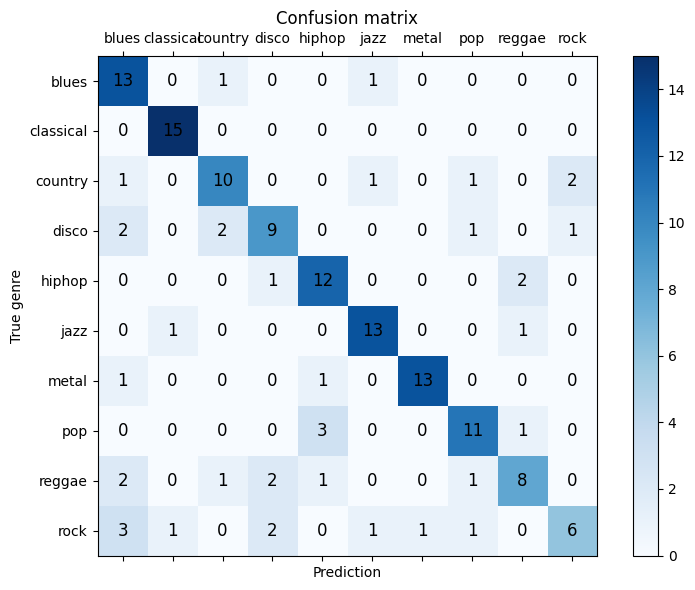

In [16]:
import matplotlib.pyplot as plt
test_accuracy = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='macro')
test_f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision (macro): {test_precision:.4f}")
print(f"F1 Score (macro): {test_f1:.4f}")
print("Confusion Matrix:")

class_names = test_dataset.label_map.keys()

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(conf_matrix, cmap='Blues')
fig.colorbar(cax)
# Dodaj etykiety osi
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Dodaj liczby do komórek
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        ax.text(j, i, str(conf_matrix[i][j]),
                va='center', ha='center', color='black', fontsize=12)

# Oznaczenia osi
plt.xlabel('Prediction')
plt.ylabel('True genre')
plt.title('Confusion matrix')
plt.tight_layout()
plt.show()


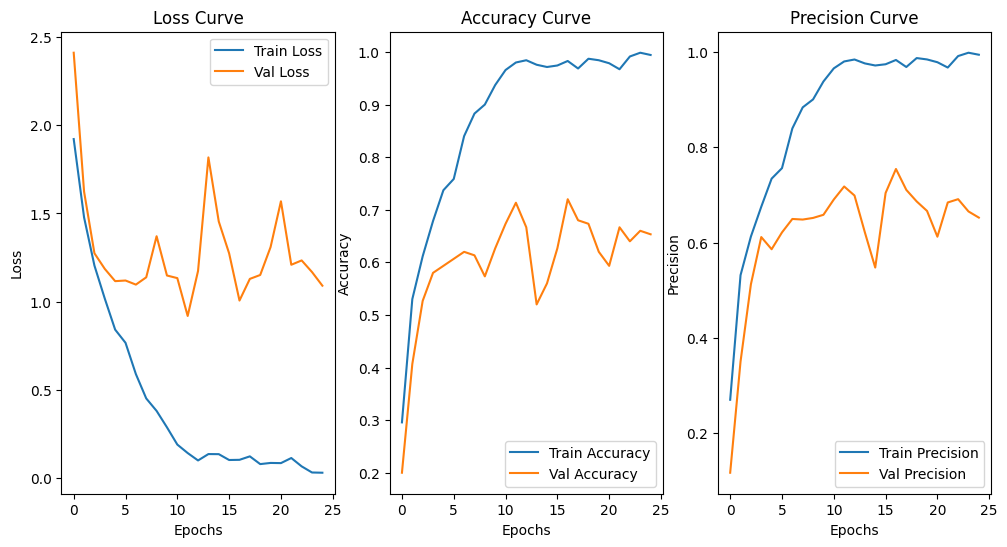

In [17]:
# Plotting the Loss and Accuracy curves
plt.figure(figsize=(12, 6))

# Losses
plt.subplot(1, 3, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(num_epochs), val_accuracies, label='Val Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Precision
plt.subplot(1, 3, 3)
plt.plot(range(num_epochs), train_precisions, label='Train Precision')
plt.plot(range(num_epochs), val_precisions, label='Val Precision')
plt.title("Precision Curve")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()

plt.show()

In [18]:

torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_precisions: ': train_precisions,
    'val_precisions': val_precisions,
    'test_accuracy' : test_accuracy,
    'test_precision' : test_precision,
    'test_f1': test_f1,
    'conf_matrix': conf_matrix
}, get_filename_with_date())

In [ ]:
'''
torch.save(model.state_dict(), 'model.pth')
'''

In [ ]:
'''

num_classes = 10
model = densenet121()
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model.load_state_dict(torch.load('model.pth'))
model.eval()
success = 0
val_size = 1
for elem in val_dataset:
    image, label = elem
    with torch.no_grad():
        output = model(image.unsqueeze(0))
    _, predicted = torch.max(output, 1)

    if predicted == label:
        success += 1
    val_size += 1
print(success/val_size)

'''